In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import copy

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [5]:
subjects = [1]
n_subjects=len(subjects)
n_rois = 11
make_time_resolved=False
use_bigIPS=True

# first load all data for all subjects, all tasks
maindat_all = []; repdat_all = []
mainlabs_all = []; replabs_all = []

for si, ss in enumerate(subjects):

    print('loading S%02d, main task'%ss)
    main_data, _, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved, use_bigIPS)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        main_data[ri] -= np.tile(np.mean(main_data[ri], axis=1, keepdims=True), [1, main_data[ri].shape[1]])

    maindat_all += [main_data]
    mainlabs_all += [main_labels]

    print('loading S%02d, repeat task'%ss)
    rep_data, _, rep_labels, roi_names = data_utils.load_repeat_task_data(ss, make_time_resolved, use_bigIPS)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        rep_data[ri] -= np.tile(np.mean(rep_data[ri], axis=1, keepdims=True), [1, rep_data[ri].shape[1]])

    repdat_all += [rep_data]
    replabs_all += [rep_labels]


loading S01, main task
loading S01, repeat task


In [6]:
c_values = np.logspace(-9, 1, 20)
n_grid_pts = 16
    

In [8]:
si = 0;
main_data = maindat_all[si]
main_labels = mainlabs_all[si]
rep_data = repdat_all[si]
rep_labels = replabs_all[si]

# gathering labels for main task and for repeat task.
# all labels will be concatenated [main; repeat]
inds_use_main = (main_labels['is_main_grid']==True) 
inds_use_rep = (rep_labels['is_main_grid']==True) 

xlabs_main = np.array(main_labels['ptx'])[inds_use_main]
ylabs_main = np.array(main_labels['pty'])[inds_use_main]
xlabs_rep = np.array(rep_labels['ptx'])[inds_use_rep]
ylabs_rep = np.array(rep_labels['pty'])[inds_use_rep]

xlabs = np.concatenate([xlabs_main, xlabs_rep], axis=0)
ylabs = np.concatenate([ylabs_main, ylabs_rep], axis=0)

pt_labs = np.array([xlabs, ylabs]).T
grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, return_inverse=True, return_counts=True)
assert(n_grid_pts==grid_pts.shape[0])

# cross-validation labels, leave-one-run-out
cv_labs_main = np.array(main_labels['run_overall'])[inds_use_main]
cv_labs_rep = np.array(rep_labels['run_overall'])[inds_use_rep]
cv_labs_rep += np.max(cv_labs_main)

cv_labs = np.concatenate([cv_labs_main, cv_labs_rep], axis=0)
n_cv = len(np.unique(cv_labs))

# repeat task is task "4" out of 4 here
task_labs_main = np.array(main_labels['task'])[inds_use_main]
task_labs_rep = 4 * np.ones((np.sum(inds_use_rep), ), dtype=int)
task_labs = np.concatenate([task_labs_main, task_labs_rep], axis=0)

is_main_task = task_labs<4

# # convert the cv labs, instead of counting over all runs, make them count all runs within 
# # a given task only.
# cv_labs_raw = cv_labs
# cv_labs = np.zeros(np.shape(cv_labs_raw))

# for ti in range(n_tasks_trn):
#     inds = task_labs==(ti+1)
#     cv_labs[inds] = np.unique(cv_labs_raw[inds], return_inverse=True)[1]


In [24]:
# ri_combine = [5,6,7,8]
ri_combine = [5]
print(np.array(roi_names)[ri_combine])
                
dat_main = np.concatenate([main_data[ri][inds_use_main,:] \
                           for ri in ri_combine], axis=1)
dat_rep = np.concatenate([rep_data[ri][inds_use_rep,:] \
                           for ri in ri_combine], axis=1)
dat_alltasks = np.concatenate([dat_main, dat_rep], axis=0)


['IPS0']


In [25]:
n_threads = 8

In [26]:
ti = 0;
tt = 1;

# hold the predicted labels for entire dataset
pred_labs = np.full(fill_value=np.nan, shape=(np.shape(grid_labs)))

cvi = 0; np.unique(cv_labs)[0];

# for cvi, cv in enumerate(np.unique(cv_labs)):

    # if debug & (cvi>0):
    #     continue

# training dat is the training task of interest, leaving out one run.
trninds = (task_labs==tt) & (cv_labs!=cv)

trnlabs = grid_labs[trninds]

trndat = dat_alltasks[trninds,:]

print(' training task %d, cv %d: %d total trials'%(tt, cv, trndat.shape[0]))

# do regularization parameter (c) selection
# this is based on training data only, for the current fold.
# cross-validate using leave-one-run-out (for just the training runs here)
nest_cv_labs = cv_labs[trninds]
nest_cv_obj = sklearn.model_selection.LeaveOneGroupOut()
nest_cv_generator = nest_cv_obj.split(trndat, trnlabs, nest_cv_labs)

# define model
st = time.time()
model = sklearn.linear_model.LogisticRegressionCV(cv = nest_cv_generator, \
                                                Cs = c_values, \
                                                multi_class='multinomial',\
                                                solver='lbfgs', \
                                                penalty='l2', \
                                                n_jobs = n_threads , \
                                                max_iter = 1000)
model.fit(trndat, trnlabs)
elapsed = time.time() - st

# pull out the accuracy of the model for each C value
# averaging across the nested CV folds
a = np.mean(model.scores_[0], axis=0)
c = model.C_[0]
assert(c_values[np.argmax(a)]==c)


 training task 1, cv 1: 352 total trials


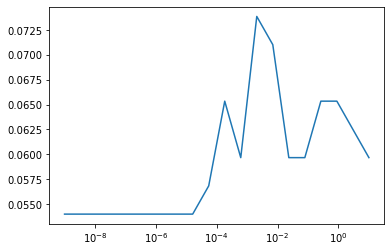

In [27]:
plt.figure()
plt.plot(c_values, a)
plt.gca().set_xscale('log')


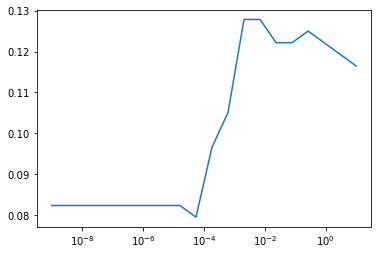

In [23]:
plt.figure()
plt.plot(c_values, a)
plt.gca().set_xscale('log')


In [21]:
1/16

0.0625

In [18]:
trndat.shape

(352, 3054)

In [9]:
[main_data[rr].shape for rr in range(11)]

[(1728, 1866),
 (1728, 1236),
 (1728, 1109),
 (1728, 1013),
 (1728, 277),
 (1728, 950),
 (1728, 628),
 (1728, 789),
 (1728, 687),
 (1728, 369),
 (1728, 152)]

In [5]:
main_data, _, main_labels, roi_names = data_utils.load_main_task_data(1, make_time_resolved=False, \
                                                                      use_bigIPS=False)


In [6]:
[main_data[rr].shape for rr in range(11)]

[(1728, 1866),
 (1728, 1236),
 (1728, 1109),
 (1728, 1013),
 (1728, 277),
 (1728, 476),
 (1728, 182),
 (1728, 85),
 (1728, 271),
 (1728, 369),
 (1728, 152)]

In [3]:
debug=False

subjects = np.arange(1,8)
n_subj = len(subjects)

task_names = ['Linear (1)','Linear (2)','Checker'];
n_tasks = len(task_names)

# three different ways to do binary decoding
n_bounds = 3;
bound_names = ['Decode: Linear (1)','Decode: Linear (2)','Decode: Checker'];
quad_groups = [[[1, 4], [2, 3]],
                [[1, 2], [3, 4]],
                [[1, 3], [2, 4]]];

make_time_resolved = False

n_rois = 11

# first load all data for all subjects, both tasks
maindat_all = []; repdat_all = []
mainlabs_all = []; replabs_all = []

for si, ss in enumerate(subjects):
    # si = 0; ss = 1;

    print('loading S%02d, main task'%ss)
    main_data, _, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        main_data[ri] -= np.tile(np.mean(main_data[ri], axis=1, keepdims=True), [1, main_data[ri].shape[1]])

    maindat_all += [main_data]
    mainlabs_all += [main_labels]

    print('loading S%02d, repeat task'%ss)
    rep_data, _, rep_labels, roi_names = data_utils.load_repeat_task_data(ss, make_time_resolved)

    for ri in range(n_rois):
        # subtract mean across voxels each trial
        rep_data[ri] -= np.tile(np.mean(rep_data[ri], axis=1, keepdims=True), [1, rep_data[ri].shape[1]])

    repdat_all += [rep_data]
    replabs_all += [rep_labels]


loading S01, main task
loading S01, repeat task
loading S02, main task
loading S02, repeat task
loading S03, main task
loading S03, repeat task
loading S04, main task
loading S04, repeat task
loading S05, main task
loading S05, repeat task
loading S06, main task
loading S06, repeat task
loading S07, main task
loading S07, repeat task


In [5]:
n_grid_pts = 16

In [25]:
si = 0;
ri = 0;

main_data = maindat_all[si]
main_labels = mainlabs_all[si]
rep_data = repdat_all[si]
rep_labels = replabs_all[si]

# gathering labels for main task and for repeat task.
# all labels will be concatenated [main; repeat]
inds_use_main = (main_labels['is_main_grid']==True) 
inds_use_rep = (rep_labels['is_main_grid']==True) 

xlabs_main = np.array(main_labels['ptx'])[inds_use_main]
ylabs_main = np.array(main_labels['pty'])[inds_use_main]
xlabs_rep = np.array(rep_labels['ptx'])[inds_use_rep]
ylabs_rep = np.array(rep_labels['pty'])[inds_use_rep]

xlabs = np.concatenate([xlabs_main, xlabs_rep], axis=0)
ylabs = np.concatenate([ylabs_main, ylabs_rep], axis=0)

pt_labs = np.array([xlabs, ylabs]).T
grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, return_inverse=True, return_counts=True)
assert(n_grid_pts==grid_pts.shape[0])

# cross-validation labels, leave-one-run-out
cv_labs_main = np.array(main_labels['run_overall'])[inds_use_main]
cv_labs_rep = np.array(rep_labels['run_overall'])[inds_use_rep]
cv_labs_rep += np.max(cv_labs_main)

cv_labs = np.concatenate([cv_labs_main, cv_labs_rep], axis=0)
n_cv = len(np.unique(cv_labs))

# convert the cv labs, instead of counting over all runs, make them count all runs within 
# a given task only.
cv_labs_raw = cv_labs
cv_labs = np.zeros(np.shape(cv_labs_raw))

for ti in range(n_tasks_trn):
    inds = task_labs==(ti+1)
    cv_labs[inds] = np.unique(cv_labs_raw[inds], return_inverse=True)[1]
    
# repeat task is task "4" out of 4 here
task_labs_main = np.array(main_labels['task'])[inds_use_main]
task_labs_rep = 4 * np.ones((np.sum(inds_use_rep), ), dtype=int)
task_labs = np.concatenate([task_labs_main, task_labs_rep], axis=0)

is_main_task = task_labs<4

In [11]:
n_tasks_trn = 4

In [21]:
cv_labs_crosstask = cv_labs

for ti in range(n_tasks_trn):
    
    inds = task_labs==(ti+1)
    
    cv_labs_crosstask[inds] = np.unique(cv_labs[inds], return_inverse=True)[1]

384
[ 1  2  7  8 17 18 23 24 27 28 33 34]
384
[ 3  4  9 10 13 14 19 20 29 30 35 36]
384
[ 5  6 11 12 15 16 21 22 25 26 31 32]
384
[37 38 39 40 41 42 43 44 45 46 47 48]


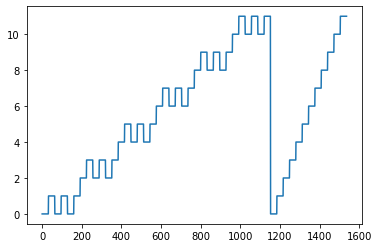

In [28]:
plt.figure()
plt.plot(cv_labs)

In [19]:
np.unique(cv_labs_crosstask[inds], return_inverse=True)

(array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6

In [7]:
cv_labs

array([ 1,  1,  1, ..., 48, 48, 48])